# Task 3

In [27]:
import torch
from torchvision.transforms import functional as F
from torchvision.datasets import CocoDetection
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from IPython.display import display, Image


In [28]:
def render(image):
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
    if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_bytes = cv2.imencode('.jpg', image)[1].tobytes()
    display(Image(data=img_bytes))
    
def loadImage(path):
    img = cv2.imread(os.path.join('', f'{path}'))
    return img

In [5]:
class LegoDataset(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        img = F.to_tensor(img)
        
        # Convert target to desired format
        boxes = []
        labels = []
        for obj in target:
            xmin, ymin, width, height = obj['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            labels.append(obj['category_id'])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        
        return img, target

dataset = LegoDataset('data/imgs', 'faster_r_cnn.json')

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [29]:
def get_model(num_classes):
    # Load a pre-trained model for classification and return only the features
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

num_classes = 2 # 1 class (lego) + background
model = get_model(num_classes)

/home/m/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/m/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# Move model to the correct device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    print(f"Epoch {epoch} finished.")

# Save the model
torch.save(model.state_dict(), 'lego_fasterrcnn.pth')


Epoch 0 finished.


In [31]:
# Load the trained model
model.load_state_dict(torch.load('lego_fasterrcnn.pth'))
model.eval()

def predict(image_path):
    image = loadImage(image_path)
    image_tensor = F.to_tensor(image).unsqueeze(0)
    with torch.no_grad():
        prediction = model(image_tensor)
    return prediction

In [34]:
# Make a prediction
image_path = '../data/imgs/1_1.jpg'
prediction = predict(image_path)[0]

tensor([116.6627,  88.1037, 154.0497, 128.7520])


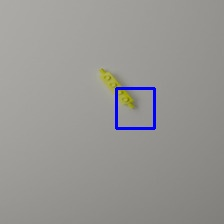

In [36]:
image = loadImage(image_path)

# Draw boxes on the image
boxes = prediction['boxes']
scores = prediction['scores']

for box, score in zip(boxes, scores):
    print(box)
    box = [int(i) for i in box.tolist()]
    image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    
render(image)